In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from sklearn.model_selection import train_test_split

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [9]:
%run ../common_code.ipynb

In [4]:
data = pd.read_csv("../../datasets/credit.csv")
print(data.columns)
#data = data.reset_index().drop(columns=["index"])
n_features = data.shape[1]-1
n = data.shape[0]
data["default"] = (data["NumberOfTimes90DaysLate"] > 0).astype(int)
data.drop(columns=["NumberOfTimes90DaysLate", 'NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs',
                   'NumberOfTime30-59DaysPastDueNotWorse'], inplace=True)
n_features = data.shape[1]-1
n = data.shape[0]
data.rename(columns={feat: "".join(feat.split("-")) for feat in data.columns}, inplace=True)
target = "default"
features = data.columns.difference([target]).tolist()

data.head(10)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'SeriousDlqin2yrs'],
      dtype='object')


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,default
0,0.006999,38,0.302150,5440.0,4,1,3,0
1,0.704592,63,0.471441,8000.0,9,1,0,0
2,0.063113,57,0.068586,5000.0,17,0,0,0
3,0.368397,68,0.296273,6250.0,16,2,0,0
4,1.000000,34,0.000000,3500.0,0,0,1,0
5,0.051799,63,0.770687,4700.0,16,1,1,0
6,0.648733,40,0.402060,6600.0,10,2,3,0
7,0.767270,33,0.338390,5800.0,10,0,3,0
8,0.190111,27,0.164605,3960.0,6,0,1,0
9,0.139989,65,0.258397,6400.0,6,1,0,0


In [14]:
data_tv, data_test = train_test_split(data, test_size=0.15, random_state=42,
                                      stratify=data[target])

data_train, data_val = train_test_split(data_tv, test_size=0.15, random_state=42,
                                      stratify=data_tv[target])

data_train[target].mean(), data_val[target].mean() , data_test[target].mean()

(0.18476190476190477, 0.18488972313467855, 0.18460925039872408)

In [16]:
data_val.shape

(2131, 8)

In [17]:
model = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model.fit(data_train[features], data_train[target])

GradientBoostingClassifier(n_estimators=30)

In [18]:
data_errors = data_val.copy(deep=True)
probs = model.predict_proba(data_val[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data_val[target]+(probs)*(1-data_val[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
700,1.000000,54,0.178841,3175.0,1,0,1,0.485031
15405,1.000000,35,0.000000,1800.0,0,0,0,0.573427
16522,0.197965,49,0.120713,9708.0,7,2,2,0.061616
3834,0.107234,80,0.271530,2960.0,8,1,0,0.054690
10225,0.594406,39,0.537291,4665.0,6,1,4,0.177077


In [19]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,DebtRatio,MonthlyIncome,NumberOfDependents,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,RevolvingUtilizationOfUnsecuredLines,age,inconf_error
0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,1,0,1
2,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,2,0
4,0,0,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2126,0,0,1,0,0,1,0,1
2127,0,0,0,0,0,1,0,1
2128,0,0,1,1,0,0,1,0
2129,0,0,0,0,0,1,0,1


In [21]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval

In [22]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [0, 2, 3, 5, 7]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7], v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

In [23]:
disc_data = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,0,2
1,2,0,0,0,0,1,0,2
2,1,1,0,2,0,2,1,0
3,0,2,1,0,0,2,0,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,1,2
2127,2,0,0,1,0,1,0,2
2128,1,1,0,2,1,2,1,1
2129,2,0,0,1,0,1,0,2


In [24]:
disc_data['inconf_error'].value_counts()

inconf_error
1    851
2    640
0    640
Name: count, dtype: int64

In [25]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [26]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'RevolvingUtilizationOfUnsecuredLines': 3,
 'age': 3,
 'DebtRatio': 3,
 'MonthlyIncome': 3,
 'NumberOfOpenCreditLinesAndLoans': 3,
 'NumberRealEstateLoansOrLines': 2,
 'NumberOfDependents': 3,
 'inconf_error': 3}

In [27]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]

In [28]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [29]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,NumberOfOpenCreditLinesAndLoans,Discrete,disc,[],[]
1,NumberRealEstateLoansOrLines,Discrete,disc,[NumberOfOpenCreditLinesAndLoans],[disc]
2,RevolvingUtilizationOfUnsecuredLines,Discrete,disc,[NumberOfOpenCreditLinesAndLoans],[disc]
3,inconf_error,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberO...","[disc, disc]"
4,DebtRatio,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberR...","[disc, disc]"
5,age,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines, NumberR...","[disc, disc]"
6,MonthlyIncome,Discrete,disc,"[DebtRatio, NumberRealEstateLoansOrLines]","[disc, disc]"
7,NumberOfDependents,Discrete,disc,[age],[disc]


In [30]:
from itertools import product

In [31]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,RevolvingUtilizationOfUnsecuredLines_0,RevolvingUtilizationOfUnsecuredLines_1,RevolvingUtilizationOfUnsecuredLines_2,age_0,age_1,age_2,DebtRatio_0,DebtRatio_1,DebtRatio_2,MonthlyIncome_0,...,NumberOfOpenCreditLinesAndLoans_1,NumberOfOpenCreditLinesAndLoans_2,NumberRealEstateLoansOrLines_1,NumberRealEstateLoansOrLines_2,NumberOfDependents_0,NumberOfDependents_1,NumberOfDependents_2,inconf_error_0,inconf_error_1,inconf_error_2
0,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,1,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0
3,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,1,0,0,1,0,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,0,0,1,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,1
2127,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2128,0,1,0,0,1,0,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
2129,0,0,1,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [32]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "inconf_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "inconf_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-04-06 19:32:52,116 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,117 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,118 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,120 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,121 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,121 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,122 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,123 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,125 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-04-06 19:32:52,126 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [33]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,DebtRatio_1,Discrete,disc,[],[]
1,MonthlyIncome_1,Discrete,disc,[],[]
2,MonthlyIncome_0,Discrete,disc,[DebtRatio_1],[disc]
3,RevolvingUtilizationOfUnsecuredLines_1,Discrete,disc,[MonthlyIncome_0],[disc]
4,DebtRatio_0,Discrete,disc,[RevolvingUtilizationOfUnsecuredLines_1],[disc]
5,NumberRealEstateLoansOrLines_2,Discrete,disc,"[DebtRatio_0, DebtRatio_1, MonthlyIncome_0, Mo...","[disc, disc, disc, disc]"
6,NumberRealEstateLoansOrLines_1,Discrete,disc,"[DebtRatio_0, DebtRatio_1, MonthlyIncome_0, Mo...","[disc, disc, disc, disc]"
7,NumberOfOpenCreditLinesAndLoans_0,Discrete,disc,"[DebtRatio_0, MonthlyIncome_0, NumberRealEstat...","[disc, disc, disc]"
8,RevolvingUtilizationOfUnsecuredLines_2,Discrete,disc,"[DebtRatio_1, NumberOfOpenCreditLinesAndLoans_...","[disc, disc, disc]"
9,age_2,Discrete,disc,"[RevolvingUtilizationOfUnsecuredLines_1, Revol...","[disc, disc]"


In [34]:
info = gbn.get_info()
info.iloc[18, 3]

['RevolvingUtilizationOfUnsecuredLines_0',
 'RevolvingUtilizationOfUnsecuredLines_2',
 'NumberOfOpenCreditLinesAndLoans_0']

In [36]:
gbn.fit_parameters(data=disc_data_encoded, n_jobs=1)

In [41]:
gbn['inconf_error_2'].disc_parents

['RevolvingUtilizationOfUnsecuredLines_0',
 'RevolvingUtilizationOfUnsecuredLines_2',
 'NumberOfOpenCreditLinesAndLoans_0']

In [ ]:
gbn.plot("credit_classif_other.html")

In [ ]:
gbn.get_dist('inconf_error_2', )

AttributeError: 'list' object has no attribute 'tolist'

In [44]:
gbn.distributions['inconf_error_2']

{'cprob': {"['0', '1', '1']": [0.11704312114989733, 0.8829568788501027],
  "['0', '1', '0']": [0.6405228758169934, 0.35947712418300654],
  "['0', '0', '1']": [0.805699481865285, 0.19430051813471502],
  "['0', '0', '0']": [0.9010752688172043, 0.0989247311827957],
  "['1', '1', '1']": [0.5, 0.5],
  "['1', '1', '0']": [0.5, 0.5],
  "['1', '0', '1']": [0.950920245398773, 0.049079754601226995],
  "['1', '0', '0']": [0.9426751592356688, 0.05732484076433121]},
 'vals': ['0', '1']}

In [45]:
features

['DebtRatio',
 'MonthlyIncome',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'RevolvingUtilizationOfUnsecuredLines',
 'age']

In [48]:
feat_to_grad = {}
for feat in features:
    feat_to_grad[feat]=[grad for grad in disc_data_encoded.columns if feat in grad]
feat_to_grad

{'DebtRatio': ['DebtRatio_0', 'DebtRatio_1', 'DebtRatio_2'],
 'MonthlyIncome': ['MonthlyIncome_0', 'MonthlyIncome_1', 'MonthlyIncome_2'],
 'NumberOfDependents': ['NumberOfDependents_0',
  'NumberOfDependents_1',
  'NumberOfDependents_2'],
 'NumberOfOpenCreditLinesAndLoans': ['NumberOfOpenCreditLinesAndLoans_0',
  'NumberOfOpenCreditLinesAndLoans_1',
  'NumberOfOpenCreditLinesAndLoans_2'],
 'NumberRealEstateLoansOrLines': ['NumberRealEstateLoansOrLines_1',
  'NumberRealEstateLoansOrLines_2'],
 'RevolvingUtilizationOfUnsecuredLines': ['RevolvingUtilizationOfUnsecuredLines_0',
  'RevolvingUtilizationOfUnsecuredLines_1',
  'RevolvingUtilizationOfUnsecuredLines_2'],
 'age': ['age_0', 'age_1', 'age_2']}

In [75]:
def error_based_importance(data, error_col, feature):
    error_probs = {grad: data[grad].mean() for grad in disc_data_encoded.columns if error_col in grad}
    s=0
    for grad in feat_to_grad[feature]:
        sub_sum = 0
        for e, p in error_probs.items():
            cprob = data[(data[e]==1)&(data[grad]==1)].shape[0]/data.shape[0]/data[grad].mean()
            sub_sum+=cprob*np.log(cprob/p) if cprob>0 else 0
        s+=data[grad].mean()*sub_sum
    return s

def mutual_information(data, error_col, feature):
    s=0
    for e_grad, f_grad in product([grad for grad in disc_data_encoded.columns if error_col in grad], 
                                  feat_to_grad[feature]):
        joint_prob = data[(data[e_grad]==1)&(data[f_grad]==1)].shape[0]/data.shape[0]
        px, py = data[e_grad].mean(), data[f_grad].mean()

        s+=joint_prob*np.log(joint_prob/px/py) if joint_prob>0 else 0

    return s


In [76]:
{feat: mutual_information(disc_data_encoded, 'inconf_error', feat) for feat in features}

{'DebtRatio': 0.023985480704574458,
 'MonthlyIncome': 0.03799078177774458,
 'NumberOfDependents': 0.003914508824678545,
 'NumberOfOpenCreditLinesAndLoans': 0.06424065796330923,
 'NumberRealEstateLoansOrLines': 0.04254980551041559,
 'RevolvingUtilizationOfUnsecuredLines': 0.338583564633012,
 'age': 0.04855963762783481}

In [78]:
res = {feat: error_based_importance(disc_data_encoded, 'inconf_error', feat) for feat in features}
res

{'DebtRatio': 0.023985480704574413,
 'MonthlyIncome': 0.03799078177774457,
 'NumberOfDependents': 0.003914508824678572,
 'NumberOfOpenCreditLinesAndLoans': 0.06424065796330924,
 'NumberRealEstateLoansOrLines': 0.042549805510415525,
 'RevolvingUtilizationOfUnsecuredLines': 0.338583564633012,
 'age': 0.04855963762783482}

In [57]:
disc_data_encoded['RevolvingUtilizationOfUnsecuredLines_2'].mean()

0.3003284842796809

([<matplotlib.axis.XTick at 0x1cd795f7160>,
 [Text(0, 0, 'DebtRatio'),
  Text(1, 0, 'MonthlyIncome'),
  Text(2, 0, 'NumberOfDependents'),
  Text(3, 0, 'NumberOfOpenCreditLinesAndLoans'),
  Text(4, 0, 'NumberRealEstateLoansOrLines'),
  Text(5, 0, 'RevolvingUtilizationOfUnsecuredLines'),
  Text(6, 0, 'age')])

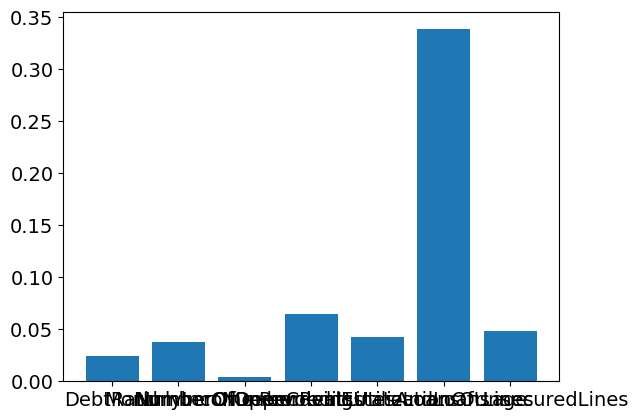

In [84]:
import matplotlib.pyplot as plt


plt.bar(range(len(res)), list(res.values()), align='center')
plt.xticks(range(len(res)), list(res.keys()))

In [120]:
model1 = GradientBoostingClassifier(n_estimators=30)
features_new=[feat for feat in features if feat!='NumberOfDependents']
#model = LogisticRegression()
model1.fit(data_train[features_new], data_train[target])

GradientBoostingClassifier(n_estimators=30)

In [121]:
from sklearn.metrics import roc_auc_score, log_loss

In [122]:
metric_dict = {
    'ROC AUC': lambda x, y: roc_auc_score(x,y)*100,
    'log_loss': lambda x, y: log_loss(x, y)
}

def compare_metrics(data_list, target_col, models, metric_dict):
    df = pd.DataFrame(columns=['model_name']+[m_name for m_name in metric_dict.keys()])
    i=0
    for data, model in zip(data_list, models):
        y_pred = model.predict_proba(data)[:, 1]
        metrics_vals = []
        for m_name, metric in metric_dict.items():
            val = metric(target_col, y_pred)
            metrics_vals.append(val)
        df.loc[i, :] = ['model_'+str(i)]+metrics_vals
        i+=1
    return df

In [123]:
compare_metrics([data_test[features], data_test[features_new]],
                data_test[target], [model, model1], metric_dict)

,model_name,ROC AUC,log_loss
0,model_0,80.188523,0.391448
1,model_1,80.155254,0.391279


In [124]:
compare_metrics([data_val[features], data_val[features_new]],
                data_val[target], [model, model1], metric_dict)

,model_name,ROC AUC,log_loss
0,model_0,78.569446,0.396653
1,model_1,78.513263,0.396708


False

In [ ]:
# наша метрика -- это же по сути взаимная информация

In [71]:
from sklearn.feature_selection import mutual_info_classif

In [72]:
mutual_info_classif(X=disc_data[['age']], y=disc_data['inconf_error'])

array([0.05289194])

In [63]:
disc_data

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,inconf_error
0,2,1,0,0,0,1,0,2
1,2,0,0,0,0,1,0,2
2,1,1,0,2,0,2,1,0
3,0,2,1,0,0,2,0,0
4,1,0,2,1,0,2,2,1
...,...,...,...,...,...,...,...,...
2126,2,0,0,0,0,1,1,2
2127,2,0,0,1,0,1,0,2
2128,1,1,0,2,1,2,1,1
2129,2,0,0,1,0,1,0,2
